# Historical Text Normalization: character-level sequence-to-sequence model (seq2seq)


based on: https://github.com/keras-team/keras-io/blob/master/examples/nlp/lstm_seq2seq.py

In order to implement this sequence-to-sequence model, we need:
* An encoder LSTM. Its input: Historical word form (e.g. "meynteigne"). The encoder produces a vector representation of the input, which is then fed into:
* A decoder LSTM. Produces the normalized word form (e.g. "maintain"). It decodes the given vector into the desired output. 

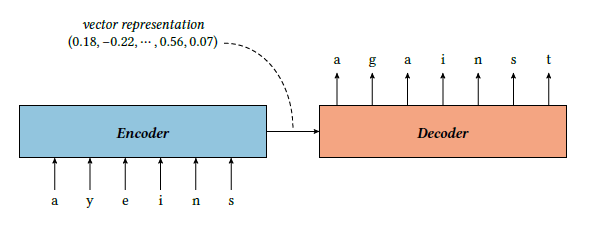

Image: Basic encoder-decoder architecture for normalization (Figure 6.1, Bollmann 2018, p.85)

## Setup: import modules

In [1]:
import numpy as np
import tensorflow as tf #if there are errors: pip3 install tensorflow on anaconda prompt
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import re
from keras.layers import LSTM
from keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot

Here, we set the batch size for training, the number of epochs for training and latent dimensionality of the encoding space:

In [2]:
batch_size = 64 
epochs = 10 
latent_dim = 256

## Downloading the data: ICAMET corpus

Note: the ICAMET Corpus is already divided into **dev**, **test** and **train** sets
<p> To use train_test_split from sklearn.model_selection, we will use one input and one output file, that have been concatenated from the given files </p>
<p> The files of the ICAMET Corpus have been converted to text files and they should be stored locally in the same path as the present jupyter notebook </p>


In [7]:
# notebook_path =os.path.abspath('seq2seq_version2.ipynb')
# dev_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_en.txt') 
# dev_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_hs.txt')

# train_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_hs.txt')
# train_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_en.txt') 

# test_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_hs.txt')
# test_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_en.txt')

In [3]:
notebook_path =os.path.abspath('seq2seq_version2.ipynb')
read_input_hs = os.path.join(os.path.dirname(notebook_path),'concatenated_input.txt')
read_output_en = os.path.join(os.path.dirname(notebook_path),'concatenated_output.txt')

Next step: read the data and save them in variables. Each sentence in the text is separated by an empty line. We add start of string and end of string token for the normalized version of the sequences

The output of the decoder will be the normalized word form as a sequence of characters with end of string symbol, so that the decoder knows when to stop generating more characters (= when to stop prediciton) and it can produce sequences of arbitrary length. 

In [4]:
with open(read_input_hs, encoding='utf8') as hs:
    input_hs = hs.read().strip().split('\n')
    input_hs = [x for x in input_hs if x] #get rid of empty strings in list

with open(read_output_en, encoding='utf8') as en:
    target_en = en.read().strip().split('\n')
    target_en = [x for x in target_en if x]
    output_en = ['<sos> ' + item +' <eos>' for item in target_en] #start of string and end of string characters

print(len(input_hs))
print(len(output_en))
print(output_en[10])
print(input_hs[10])
print(input_hs[:10])
print(output_en[:10])

182813
182813
<sos> wisest <eos>
wysest
['To', 'the', 'moost', 'noble', '&', 'Worthiest', 'Lordes', 'moost', 'ryghtful', '&']
['<sos> To <eos>', '<sos> the <eos>', '<sos> most <eos>', '<sos> noble <eos>', '<sos> and <eos>', '<sos> worthiest <eos>', '<sos> Lords <eos>', '<sos> most <eos>', '<sos> rightful <eos>', '<sos> and <eos>']


**How does the data look like?** One word per line, without context. The lists are now split into words

## preprocessing the data: lowercasing and punctuation removal 

* **Punctuation:** removing punctuation means removing noise (=cleaning the data). Thus, should we remove punctuation? <p> In our Historical English texts, we find many instances where "&" is present and translated into Modern English "and". </p> 
<p> Also, there are abbrevations such as "M." where we can't get rid of the final dot. </p>
<p> - the hyphen is an important punctuation sign that appears often in Historical English, as it is part of the original orthography </p>
<p> Based on these observations, we will remove all other punctuation signs </p>

* **Lowercasing:** Lowercasing is an important pre-processing step, as we have capitalization at the beginning of the sentence and in particular NE (as in proper nouns)-> for the sake of simplicity
<p> the lower() method turns all characters into lower case </p>

In [5]:
#remove punctuation
def clean_data(txt):
    filtered_words = []
    for i in txt:
        x=re.sub(r"[?!\/,\\(@\[){}%°~^\]+£=#$\*\)\"^]","",i)
        filtered_words.append(x)
    return filtered_words

in_hs = clean_data(input_hs)
out_en = clean_data(output_en)

#lowercasing
in_hs = [in_hs[i].lower() for i in range(len(in_hs))]
out_en = [out_en[i].lower() for i in range(len(out_en))]

print(in_hs[:10])
print(out_en[:10])

['to', 'the', 'moost', 'noble', '&', 'worthiest', 'lordes', 'moost', 'ryghtful', '&']
['<sos> to <eos>', '<sos> the <eos>', '<sos> most <eos>', '<sos> noble <eos>', '<sos> and <eos>', '<sos> worthiest <eos>', '<sos> lords <eos>', '<sos> most <eos>', '<sos> rightful <eos>', '<sos> and <eos>']


**Now, let's split the words into characters. We are interested in finding out unique characters of the input and output data: set() method**

In [6]:
input_texts = []
target_texts= []

input_char = set()
target_char = set()
for line in in_hs:
    input_texts.append(in_hs)
    for char in line:
        input_char.add(char)

for line in out_en:  
    target_texts.append(out_en)
    for char in line:
        target_char.add(char)

In [7]:
print(len(input_texts))

182813


In [8]:
print(input_char)

{'6', '§', 's', '-', '9', '‘', '‾', 'þ', 'f', '\x15', 'é', '5', '\uf06d', 'g', "'", 'm', 'h', 'd', '7', 't', '‚', 'w', 'i', '4', '…', 'n', 'à', '`', 'c', '’', '3', 'l', ' ', 'y', '—', 'r', 'è', '8', 'k', '&', 'x', 'q', 'z', '1', 'ò', '.', 'ù', '“', ';', 'p', 'v', ':', 'b', '–', 'ō', '0', 'e', 'u', 'a', 'j', 'æ', 'õ', '•', 'o', '2'}


In [9]:
input_char = sorted(list(input_char))
target_char = sorted(list(target_char))
print(input_char[:10])
print(target_char[:10])

['\x15', ' ', '&', "'", '-', '.', '0', '1', '2', '3']
['\x15', ' ', '&', "'", '-', '.', '0', '1', '2', '3']


In [10]:
num_encoder_tokens = len(input_char)
num_decoder_tokens = len(target_char)

print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

#let's see how long the longest sequences are
max_encoder_seq_length = max([len(item) for item in in_hs])
max_decoder_seq_length = max([len(item) for item in out_en])

print("max sequence length in input train: " + str(max_encoder_seq_length))
print("max sequence length in target train: " + str(max_decoder_seq_length))

#print len
print("num input train:", len(input_hs))
print("num output train:", len(output_en))

Number of unique input tokens: 65
Number of unique output tokens: 62
max sequence length in input train: 19
max sequence length in target train: 31
num input train: 182813
num output train: 182813


In [11]:
#indexing
input_token_index = dict([(char, i) for i, char in enumerate(input_char)])
target_token_index = dict([(char, i) for i, char in enumerate(target_char)])

In [12]:
list(input_token_index.keys())[list(input_token_index.values()).index(10)] #search for a random index in dict

'4'

In [13]:
print(input_token_index)

{'\x15': 0, ' ': 1, '&': 2, "'": 3, '-': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, ':': 16, ';': 17, '`': 18, 'a': 19, 'b': 20, 'c': 21, 'd': 22, 'e': 23, 'f': 24, 'g': 25, 'h': 26, 'i': 27, 'j': 28, 'k': 29, 'l': 30, 'm': 31, 'n': 32, 'o': 33, 'p': 34, 'q': 35, 'r': 36, 's': 37, 't': 38, 'u': 39, 'v': 40, 'w': 41, 'x': 42, 'y': 43, 'z': 44, '§': 45, 'à': 46, 'æ': 47, 'è': 48, 'é': 49, 'ò': 50, 'õ': 51, 'ù': 52, 'þ': 53, 'ō': 54, '–': 55, '—': 56, '‘': 57, '’': 58, '‚': 59, '“': 60, '•': 61, '…': 62, '‾': 63, '\uf06d': 64}


In [14]:
print(target_token_index)

{'\x15': 0, ' ': 1, '&': 2, "'": 3, '-': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, ':': 16, ';': 17, '<': 18, '>': 19, '`': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'i': 29, 'j': 30, 'k': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46, '´': 47, 'à': 48, 'æ': 49, 'è': 50, 'é': 51, 'ò': 52, 'ù': 53, 'þ': 54, '–': 55, '—': 56, '‘': 57, '’': 58, '“': 59, '•': 60, '…': 61}


We need 3 Numpy arrays: 
1. encoder_input_data of shape (len(in_hs), max_encoder_seq_length, num_encoder_characters): vectorization of the Historical English tokens, 
2. decoder_input_data of shape (len(in_hs, max_decoder_seq_length, num_decoder_characters): vectorization of the normalized English tokens, and 
3. decoder_target_data: the same as decoder_input_data but offset by one timestep because there is no start tag in target_data

The idea is the following:
* First we encode the input sequence into vectors
* we start with the target sequence with just the start of sequence character
* then we need to feed the vectors and the target sequence with the start of sequence character to the decoder to produce predictions for the next character
* then we sample the next character using these predictions with argmax
* append the sampled character to the target sequence
* repeat until we generate end of sequence character or character limit

In [15]:
encoder_input_data = np.zeros(
(len(in_hs), max_encoder_seq_length, num_encoder_tokens), dtype='float32'
)

decoder_input_data = np.zeros(
(len(in_hs), max_decoder_seq_length, num_decoder_tokens), dtype='float32'
)

decoder_target_data = np.zeros(
(len(in_hs), max_decoder_seq_length, num_decoder_tokens), dtype='float32'
)

print("encoder_input_data",encoder_input_data.shape)
print("decoder_input_data",decoder_input_data.shape)
print("decoder_target_data",decoder_target_data.shape)

encoder_input_data (182813, 19, 65)
decoder_input_data (182813, 31, 62)
decoder_target_data (182813, 31, 62)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(encoder_input_data, decoder_input_data, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(146250, 19, 65) (36563, 19, 65) (146250, 31, 62) (36563, 31, 62)


In [24]:
for i in range(len(in_hs)):
    for t, char in enumerate(in_hs[i]):
        encoder_input_data[i, t, input_token_index[char]] = 1
    for t, char in enumerate(out_en[i]):
        decoder_input_data[i, t, target_token_index[char]] = 1
        if t > 0:
            # decoder_target_data is ahead of decoder_input_data by one timestep
            # and will not include the start character
            decoder_target_data[i, t - 1, target_token_index[char]] = 1
            
# for i in range(len(X_train)):
#     for t, char in enumerate(X_train[i]):
#         encoder_input_data[i, t, input_token_index[char]] = 1
#     for t, char in enumerate(y_train[i]):
#         decoder_input_data[i, t, target_token_index[char]] = 1
#         if t > 0:
#             # decoder_target_data is ahead of decoder_input_data by one timestep
#             # and will not include the start character
#             decoder_target_data[i, t - 1, target_token_index[char]] = 1

## Build the model

Create the encoder-decoder model. The encoder reads the input sequence and the decoder predicts the output sequence (1 character per output)
* **loss function: categorical crossentropy**
* **optimizer: rmsprop** (preferred for NLP tasks)

**Input of the encoder:** sequence of characters as one-hot vectors with num_encoder_tokens (the length of the input characters)

In [25]:
# Encoder model
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Discard encoder_outputs and only keep the states
encoder_states = [state_h, state_c]

In [26]:
#Decoder model
# encoder_states are used as initial state
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# Set up the decoder to return full output sequences, 
# and to return internal states as well
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

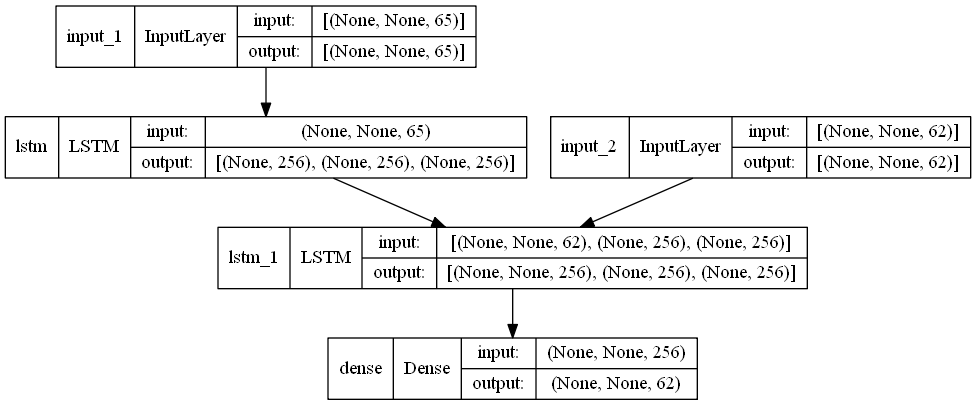

In [27]:
#model that turns encoder_input_data and decoder_input_data into decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Train the model

During each epoch, when the model is being trained, it's going to be predicting on the validation set . Loss and accuracy on training and validation set. 
<p> the model is taking what it has learned from training and trying to generalize and make a prediction on data that it has not seen before in the validation set = how well the model generalizes

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=5,
          validation_split=0.1,
          shuffle=True,
          verbose=1)
#validation set is split into 10%, 
#the model is not trained on these 10%

model.save("seq2seq") #save the model

Epoch 1/5
2571/2571 [==============================] - 441s 170ms/step - loss: 0.3735 - accuracy: 0.3965 - val_loss: 0.1825 - val_accuracy: 0.4596
Epoch 2/5
2571/2571 [==============================] - 495s 193ms/step - loss: 0.1460 - accuracy: 0.4666 - val_loss: 0.1184 - val_accuracy: 0.4721
Epoch 3/5
2571/2571 [==============================] - 431s 167ms/step - loss: 0.1098 - accuracy: 0.4732 - val_loss: 0.0949 - val_accuracy: 0.4768
Epoch 4/5
2571/2571 [==============================] - 439s 171ms/step - loss: 0.0839 - accuracy: 0.4779 - val_loss: 0.0756 - val_accuracy: 0.4796
Epoch 5/5
2571/2571 [==============================] - 451s 175ms/step - loss: 0.0721 - accuracy: 0.4796 - val_loss: 0.0693 - val_accuracy: 0.4806


INFO:tensorflow:Assets written to: seq2seq\assets


INFO:tensorflow:Assets written to: seq2seq\assets


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 65)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 62)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        329728      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

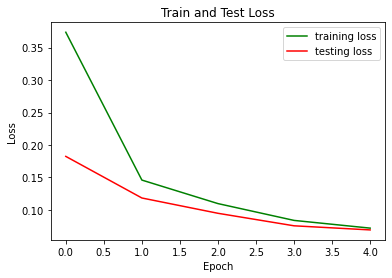

In [30]:
pyplot.plot(history.history['loss'], 'g', label='training loss')
pyplot.plot(history.history['val_loss'],  'r',label='testing loss')
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.title("Train and Test Loss")
pyplot.legend()
pyplot.show()

In [37]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=25,
          validation_split=0.1,
          shuffle=True,
          verbose=1)
#validation set is split into 10%, 
#the model is not trained on these 10%

model.save("s2s") #save the model

Epoch 1/25
2571/2571 [==============================] - 413s 160ms/step - loss: 0.0659 - accuracy: 0.4805 - val_loss: 0.0633 - val_accuracy: 0.4814
Epoch 2/25
2571/2571 [==============================] - 431s 168ms/step - loss: 0.0595 - accuracy: 0.4816 - val_loss: 0.0580 - val_accuracy: 0.4823
Epoch 3/25
2571/2571 [==============================] - 441s 171ms/step - loss: 0.0550 - accuracy: 0.4822 - val_loss: 0.0563 - val_accuracy: 0.4821
Epoch 4/25
2571/2571 [==============================] - 480s 187ms/step - loss: 0.0514 - accuracy: 0.4826 - val_loss: 0.0518 - val_accuracy: 0.4828
Epoch 5/25
2571/2571 [==============================] - 542s 211ms/step - loss: 0.0470 - accuracy: 0.4830 - val_loss: 0.0482 - val_accuracy: 0.4830
Epoch 6/25
2571/2571 [==============================] - 533s 207ms/step - loss: 0.0436 - accuracy: 0.4833 - val_loss: 0.0453 - val_accuracy: 0.4831
Epoch 7/25
2571/2571 [==============================] - 523s 204ms/step - loss: 0.0401 - accuracy: 0.4835 - val_

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


In [ ]:
model.summary()

pyplot.plot(history.history['loss'], 'g', label='training loss')
pyplot.plot(history.history['val_loss'],  'r',label='testing loss')
pyplot.xlabel("Epoch")
pyplot.ylabel("Loss")
pyplot.title("Train and Test Loss")
pyplot.legend()
pyplot.show()

In [36]:
y_pred = model.predict(X_test, batch_size=batch_size)

ValueError: in user code:

    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jolll\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 19, 65) dtype=float32>]


In [32]:
"""
## Run inference (sampling)
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states
"""

# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("seq2seq")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["<sos>"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "<eos>" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


"""
You can now generate decoded sentences as such:
"""

for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


KeyError: '<sos>'

## Test the model --> making predictions
Testing with input_test from ICAMET corpus and ARCHER corpus (first century 1600-1700) to see how well the model performs

**evaluation metrics** 
<p> accuracy: compare with the number of words that don't need to be changed  </p>
<p> precision and recall -> for words that the algorithm changed something / gold standard cases </p>

https://github.com/coastalcph/histnorm/blob/master/scripts/evaluate.py  

evaluate the model on test data via evaluate()

In [63]:
#test set

with open(test_hs, encoding='utf8') as hs_raw_test:
    input_test = hs_raw_test.read().strip().split('\n')
    input_test = [x for x in input_test if x] #get rid of empty strings in list

with open(test_en, encoding='utf8') as en_raw_test:
    target_test = en_raw_test.read().strip().split('\n')
    target_test = [x for x in target_test if x]
    output_test = ['<sos> ' + item +' <eos>' for item in target_test] #start of string token

#apply same preprocessing

punct_in_test = clean_data(input_test)
punct_out_test = clean_data(output_test)
in_test = [punct_in_test[i].lower() for i in range(len(punct_in_test))]
out_test = [punct_out_test[i].lower() for i in range(len(punct_out_test))]

In [56]:
# print("evaluate on test data")
# results= model.evaluate()
# print("test loss, test acc:", results)

In [66]:
#verbose: shows a progress bar
print("evaluate on test data")
#test accuracy
score = model.evaluate(in_test, out_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

evaluate on test data


ValueError: in user code:

    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\danyc\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>]


## Generate predictions